In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Wed Mar  5 15:24:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   27C    P8              8W /  230W |     149MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")


from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import torch
import scienceplots
plt.style.use(['science', 'no-latex'])
from IPython.display import clear_output

from src.text_utils import trim_text_to_token_limit
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from langdetect import detect

import evaluate


tqdm.pandas()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", cache_dir = '/Data')

In [5]:
torch.cuda.set_per_process_memory_fraction(0.6, device=0)


In [6]:
base_data = pd.read_json("data/wikipedia_dataset.json")

## Loading data

In [7]:
base_path = "data/generated_dataset_100_qwen-0.5b-instruct-summary-pt-checkpoint{checkpoint_idx}.pkl"

In [22]:
all_df = []
raw_model_df = pd.read_pickle("data/generated_dataset_Qwen2.5-0.5B-Instruct.pkl")
raw_model_df['checkpoint_name'] = "Raw model"

all_df.append(raw_model_df)

for i in range(4):
    temp = pd.read_pickle(base_path.format(checkpoint_idx = i))
    
    if i == 0:
        temp = pd.read_pickle(base_path.format(checkpoint_idx = "0_2"))
    
    temp['checkpoint_name'] = f"Epoch {i}"
    all_df.append(temp)


In [23]:
reference_summary = pd.read_pickle("data/generated_dataset_100_Meta-Llama-3.1-8B-Instruct-bnb-4bit_2.pkl")\
    .rename(columns = {'generated_text': 'reference_summary'})

# all_df.append(reference_summary)

In [24]:
generated_summaries = pd.concat(all_df, ignore_index=True)
generated_summaries

,id,generated_text,checkpoint_name
0,57237,A Los Angeles Lakers é uma equipe de basqueteb...,Raw model
1,10306,O elétron é uma partícula subatômica com símbo...,Raw model
2,2118886,"A rainha Sofia, filha do rei Constantino I, fo...",Raw model
3,1695,Aqui está um resumo do texto em português:\n\n...,Raw model
4,5448408,A crise migratória venezuelana é uma emigração...,Raw model
...,...,...,...
16995,10831,"O texto apresenta eventos históricos, incluind...",Epoch 3
16996,10889,"O texto apresenta eventos históricos, incluind...",Epoch 3
16997,10892,"O texto apresenta eventos históricos, incluind...",Epoch 3
16998,10883,"O texto apresenta eventos históricos, incluind...",Epoch 3


In [25]:
df = pd.merge(
    generated_summaries,
    reference_summary,
    on='id',
    how = 'left'
)
df

,id,generated_text,checkpoint_name,reference_summary
0,57237,A Los Angeles Lakers é uma equipe de basqueteb...,Raw model,O Los Angeles Lakers é um time de basquetebol ...
1,10306,O elétron é uma partícula subatômica com símbo...,Raw model,O elétron é uma partícula subatômica com carga...
2,2118886,"A rainha Sofia, filha do rei Constantino I, fo...",Raw model,"Sofia Doroteia Ulrica Alice, rainha consorte d..."
3,1695,Aqui está um resumo do texto em português:\n\n...,Raw model,Um sistema operacional é um programa que geren...
4,5448408,A crise migratória venezuelana é uma emigração...,Raw model,A crise migratória venezuelana é uma das maior...
...,...,...,...,...
16995,10831,"O texto apresenta eventos históricos, incluind...",Epoch 3,"Infelizmente, não há texto disponível para ger..."
16996,10889,"O texto apresenta eventos históricos, incluind...",Epoch 3,"Infelizmente, não há texto disponível para ger..."
16997,10892,"O texto apresenta eventos históricos, incluind...",Epoch 3,"Infelizmente, não há texto disponível para ger..."
16998,10883,"O texto apresenta eventos históricos, incluind...",Epoch 3,"Infelizmente, não há texto disponível para ger..."


## Sequence length

We verify if the summary has ~ 100 words

In [26]:
df['reference_length'] = df['reference_summary']\
    .progress_apply(lambda x: len(x.split()))
df['generated_length'] = df['generated_text']\
    .progress_apply(lambda x: len(x.split()))

100%|██████████| 17000/17000 [00:00<00:00, 153903.47it/s]


<Axes: xlabel='reference_length', ylabel='Count'>

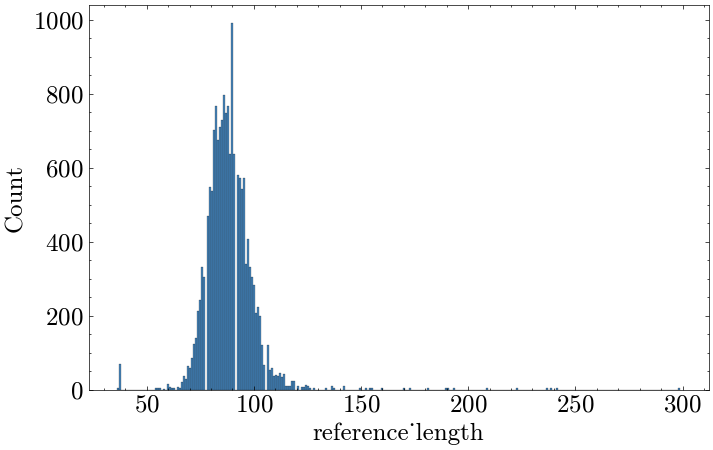

In [27]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    df,
    x = 'reference_length',
)

<Axes: xlabel='generated_length', ylabel='Count'>

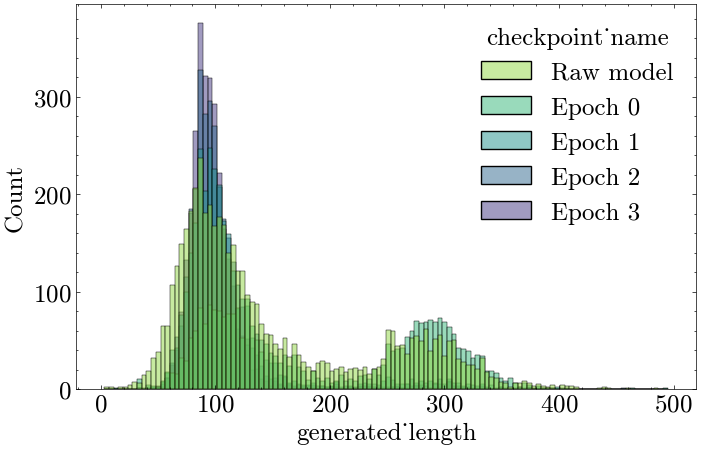

In [43]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    df,
    x = 'generated_length',
    hue='checkpoint_name',
    palette= 'viridis_r',
    # alpha = 0.6
)

## Language

Checking how many texts are not in portuguese

In [62]:
df['language'] = df['generated_text'].progress_apply(detect)

100%|██████████| 17000/17000 [00:39<00:00, 433.57it/s]


In [65]:
def count_non_portuguese_text(df):
    return (df['language'] != 'pt').sum()/len(df)

df.groupby("checkpoint_name")\
    .progress_apply(count_non_portuguese_text)

100%|██████████| 5/5 [00:00<00:00, 1215.25it/s]


checkpoint_name
Epoch 0      0.005000
Epoch 1      0.002333
Epoch 2      0.004000
Epoch 3      0.003333
Raw model    0.023800
dtype: float64

In [15]:
predictions = df["generated_text"].tolist()
references = df["reference_summary"].tolist()

In [16]:
checkpoint_groups = df.groupby("checkpoint_name")
rouge = evaluate.load("rouge")
# Store results
checkpoint_rouge_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing ROUGE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = rouge.compute(predictions=predictions, references=references)
    
    # Store the results
    checkpoint_rouge_scores[checkpoint] = scores

Computing ROUGE per checkpoint: 100%|██████████| 5/5 [01:26<00:00, 17.35s/it]


In [17]:
pd.DataFrame(checkpoint_rouge_scores).T

,rouge1,rouge2,rougeL,rougeLsum
0,0.399231,0.227885,0.303844,0.304760
1,0.508729,0.297941,0.385473,0.386386
2,0.527032,0.312444,0.399391,0.400336
3,0.536176,0.320846,0.406204,0.407146
raw model,0.402349,0.209294,0.290824,0.292813


In [18]:
checkpoint_groups = df.groupby("checkpoint_name")
bertscore = evaluate.load("bertscore")

# Store results
checkpoint_bert_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing BERT-SCORE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = bertscore.compute(predictions=predictions, references=references, lang = 'pt',)
    
    # Store the results
    checkpoint_bert_scores[checkpoint] = scores

Computing BERT-SCORE per checkpoint: 100%|██████████| 5/5 [02:30<00:00, 30.20s/it]


In [58]:
(pd.DataFrame(checkpoint_bert_scores).loc['f1'].tolist())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.443117,0.808201,0.689617,0.698662,0.714391,0.764670,0.782263,0.655890,0.733659,0.738448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.790199,0.782505,0.781579,0.799191,0.820441,0.770987,0.905978,0.476039,0.812753,0.821006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.825894,0.891816,0.859487,0.808960,0.807983,0.768575,0.922684,0.476039,0.789034,0.858813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.782626,0.873650,0.853461,0.784830,0.847583,0.793682,0.769371,0.476039,0.814143,0.837273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.713285,0.738360,0.766152,0.763714,0.801052,0.708057,0.867467,0.715916,0.720680,0.838550,...,0.651694,0.651694,0.651694,0.651694,0.651694,0.577276,0.577276,0.577276,0.577276,0.597323


In [19]:
for k in checkpoint_bert_scores.keys():
    print(k, np.mean(checkpoint_bert_scores[k]['f1']))

0 0.7331661378840605
1 0.7811527064839999
2 0.7887276373306911
3 0.7931608695983887
raw model 0.739516812390089
